In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import time

In [4]:
# The German Traffic Sign Recognition Benchmark
#
# sample code for reading the traffic sign images and the
# corresponding labels
#
# example:
#            
# trainImages, trainLabels = readTrafficSigns('GTSRB/Training')
# print len(trainLabels), len(trainImages)
# plt.imshow(trainImages[42])
# plt.show()
#

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import glob
import os


In [5]:
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data() 
# (train_images, train_labels), (test_images,test_labels) = (train_images[:5000], train_labels[:5000]), (test_images[:1000],test_labels[:1000])

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


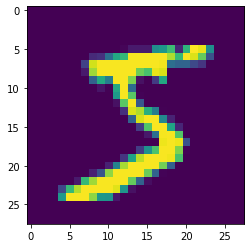

In [6]:
plt.imshow(train_images[0]);


In [7]:
train_images.shape[0]

60000

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, -1)

In [9]:
train_images = (train_images - 127.5)/127.5

In [10]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE= 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_images) \
                .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### DISCRIMINATOR MODEL

In [12]:
def make_descriminator_model():
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(7,(3,3), padding='same', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(50, activation="relu"))
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [13]:
model_discriminator = make_descriminator_model()

In [14]:
model_discriminator(np.random.rand(1,28,28,1).astype('float32'))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.08475036]], dtype=float32)>

In [16]:
disriminator_optimizer = tf.optimizers.Adam(1e-3)

In [15]:
def get_descriminator_loss(real_predictions, fake_predictions):
    real_predictions = tf.sigmoid(real_predictions)
    fake_predictions = tf.sigmoid(fake_predictions)
    
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_predictions), 
                                              real_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions),
                                              fake_predictions)
    
    return fake_loss + real_loss




## Generator

In [17]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    # H=7, W=7, filters=256  input_shape is random 100 numbers as a input
    model.add(tf.keras.layers.Dense(7*7*256, input_shape=(100,))) 
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape( (7,7,256) ))
    model.add(tf.keras.layers.Conv2DTranspose(128, (3,3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Reshape())
    model.add(tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(1, (3,3), strides=(2,2), padding='same'))
    
    return model

    

In [18]:
generator = make_generator_model()

In [19]:
generator_optimizer = tf.optimizers.Adam(1e-4)

In [20]:
def get_generator_loss(fake_predictions):
    fake_predictions = tf.sigmoid(fake_predictions)
    
    fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_predictions)\
                                              , fake_predictions)
    return fake_loss

# Training 

In [21]:
def train(dataset, epochs):
    
    for epoch in range(epochs):
        
        for images in dataset:
#             print(images.shape)
            images = tf.cast(images, tf.dtypes.float32)
            train_step(images,epoch)
            
            

In [31]:
def train_step(images, epoch):
    fake_image_noise = np.random.randn(BATCH_SIZE, 100).astype('float32')
    '''Tensorflow way of making/dealing with gradient 
        pull out gradient and to interatively use it '''
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # With generator let's generate the images and pass some random noise
        generated_images = generator(fake_image_noise)
        
        # let see how our discriminator works for real and generated images 
        real_output = model_discriminator(images)
        fake_output = model_discriminator(generated_images)
        
        # calculate the loss of generator
        gen_loss = get_generator_loss(fake_output)
        
        # calculate the loss of discriminator
        disc_loss = get_descriminator_loss( real_output, fake_output)
        
        gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradient_of_discriminator = disc_tape.gradient(disc_loss
                                                       , model_discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradient_of_generator
                                                , generator.trainable_variables))
        disriminator_optimizer.apply_gradients(zip(gradient_of_discriminator
                                                  , model_discriminator.trainable_variables))
#         if epoch % 2 == 0:
#             pass
#             print('generator loss: ', np.mean(gen_loss))
#             print('discriminator loss: ', np.mean(disc_loss))
        
        # now need to use optimizer to optimize the weights 

In [67]:
train(train_dataset, 60)

(1, 100)


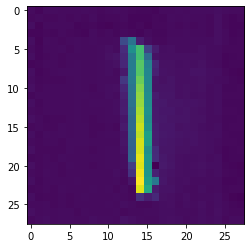

In [68]:
in_digit = np.random.randn(1,100)
print(in_digit.shape)
# print(in_digit)
plt.imshow(tf.reshape(generator(in_digit), (28,28)))

In [63]:
# for digit in range(0,10):
# #     in_digit = np.random.randn(1,100)
# #     print(in_digit.shape)
#     plt.imshow(tf.reshape(generator(digit), (28,28)))

In [29]:
a = tf.ones([3, 4, 3])
print(a.shape)
tf.image.resize_with_crop_or_pad(a, 5, 5)

(3, 4, 3)


<tf.Tensor: shape=(5, 5, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

# The German Traffic Sign Recognition Benchmark

In [ ]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    
    for c in range(0,10): #43
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        print(gtFile)
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        print("Headers:",gtReader.__next__())
        # next(gtReader)
        #gtReader.next() # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

<_io.TextIOWrapper name='GTSRB/Final_Training/Images//00000/GT-00000.csv' mode='r' encoding='UTF-8'>
Headers: ['Filename', 'Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId']
<_io.TextIOWrapper name='GTSRB/Final_Training/Images//00001/GT-00001.csv' mode='r' encoding='UTF-8'>
Headers: ['Filename', 'Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId']
<_io.TextIOWrapper name='GTSRB/Final_Training/Images//00002/GT-00002.csv' mode='r' encoding='UTF-8'>
Headers: ['Filename', 'Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId']
<_io.TextIOWrapper name='GTSRB/Final_Training/Images//00003/GT-00003.csv' mode='r' encoding='UTF-8'>
Headers: ['Filename', 'Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId']
<_io.TextIOWrapper name='GTSRB/Final_Training/Images//00004/GT-00004.csv' mode='r' encoding='UTF-8'>
Headers: ['Filename', 'Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId']
<_io.TextIOWrapper name='GTSRB/Fina

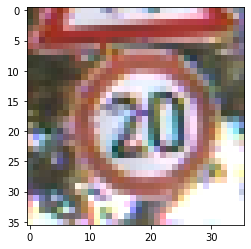

In [ ]:
train_path="GTSRB/Final_Training/Images/"
trainImages, trainLabels = readTrafficSigns(train_path)
print(len(trainLabels), len(trainImages))
plt.imshow(trainImages[42]);
plt.show();

In [ ]:
import tensorflow.compat.v1 as tfGk

In [ ]:
noise_limit = 0.35
noise_l2_weight = 0.02
ADVERSARY_VARIABLES = 'adversary_variables'


In [ ]:
collections = [tfGk.GraphKeys.GLOBAL_VARIABLES, ADVERSARY_VARIABLES]

In [ ]:
x_noise = tf.Variable(tf.zeros([img_size, img_size, num_channels]),
                      name='x_noise', trainable=False,
                      collections=collections)